# Classical error codes

Information is an inherently physical object. To communicate it we must attach it to a physical manifestation such as speech, writing or actions. Any physical system can fail and when it does the information it carries can be lost or distorted.

Suppose Alice and Bob agree that Alice will turn the kitchen light on if she is working from home and turn it off otherwise. The idea is efficient but it depends entirely on the light functioning. If the bulb fails, Bob may draw the wrong conclusion despite Alice’s intention remaining unchanged. To reduce this risk Alice could instead turn on the kitchen, bedroom and bathroom lights. It is unlikely that all three bulbs fail at once, so Bob is far more likely to receive the intended message.

This is an example of classical error correction. Using multiple bulbs introduces redundancy into the communication channel so that even when parts of the physical system fail the original message can still be recovered. The goal of error correction is to introduce redundancy and structure into the communication channel so that the information remains intact despite physical imperfections.

## Encoding messages as binary strings

We can encode the light switch example using binary numbers. The switch is either on or off, which we encode as 
$1$ for on and $0$ for off. This is an example of a bit. A bit represents a physical system with two states, labelled $0$ and $1$.

Errors can occur when a bit changes state: for example a $0$ becomes a $1$ or a $1$ becomes a $0$. These are called bit-flip errors. For example, if Alice tries to send $1$ by turning the light on but the bulb fails, Bob will interpret it as a $0$ and misread the message.

A simple way to reduce errors is to increase redundancy by sending multiple copies of the same bit. We then assume that the value appearing most often is the intended message. For example, suppose that Alice sends $111$ and each bulb has probability $0.1$ of failure. Suppose that Bob receives $101$. The probability that only the middle bit flipped is $0.9 \cdot 0.1 \cdot 0.9 = 0.081$, whereas the probability the other two bits flipped is $0.1 \cdot 0.9 \cdot 0.1 = 0.009$. Therefore, it is much more likely that only one bit flipped and the intended message was $111$. In general, the most likely codeword is the one where the fewest bits have flipped, which corresponds to the majority of bits. This method is called majority decoding.

The more copies Alice sends the more likely Bob will choose the intended message. However, there is a trade-off. Sending more copies also increases the number of bits Bob must check, which takes more time and reduces efficiency. We can see this in the following example.

#### Example. 
Before moving on to general error correction codes we consider an implementation of the light switch example above.

In [5]:
import random

error_prob = 0.25

def send_bit(bit, error_prob) -> int:
    """ 
    Sends one bit across a noisy channel.
    Each bit has probability error_prob at being flipped.
    """
    if random.random() < error_prob:
        return (bit + 1) % 2
    return bit

send_bit_trials = 10
error_prob = 0.2
for send_bit_trial in range(send_bit_trials):
    bit = random.choice([0,1])
    received_bit = send_bit(bit, error_prob)
    print(f"Sent bit: {bit}. Received bit: {received_bit}. Error occured? {bit != received_bit}.")

Sent bit: 1. Received bit: 1. Error occured? False.
Sent bit: 0. Received bit: 0. Error occured? False.
Sent bit: 0. Received bit: 0. Error occured? False.
Sent bit: 0. Received bit: 0. Error occured? False.
Sent bit: 0. Received bit: 0. Error occured? False.
Sent bit: 0. Received bit: 0. Error occured? False.
Sent bit: 0. Received bit: 0. Error occured? False.
Sent bit: 1. Received bit: 1. Error occured? False.
Sent bit: 0. Received bit: 1. Error occured? True.
Sent bit: 1. Received bit: 1. Error occured? False.


To improve reliability, we can increase the number of light bulbs, or equivalently increase the number of bits in our binary strings. Let us consider the case with three light switches.

In [ ]:
def decode_message(bits):
    return 1 if sum(bits) > len(bits)//2 else 0

print(f"\nThree light switches")

send_three_bit_trials = 5
error_prob = 0.2
num_correct = 0
for _ in range(send_three_bit_trials): 
    alice_intended = random.choice([0,1])
    alice_message = [alice_intended]*3
    bob_message = [send_bit(bit, error_prob) for bit in alice_message]
    bob_interpretation = decode_message(bob_message)
    print(f"\nAlice intended: {alice_intended}. Alice sent: {alice_message}. Bob received: {bob_message}. Bob interpreted: {bob_interpretation}.")
    print(f"    Interpretation correct? {alice_intended == bob_interpretation}.")
    if alice_intended == bob_interpretation:
        num_correct += 1
print(f"\nPercentage of correct interpretations: {float(num_correct/send_three_bit_trials)}.")



However, as the number of bits increases, the time required to decode the message also grows, since there are more bits to check.

<function matplotlib.pyplot.show(close=None, block=None)>

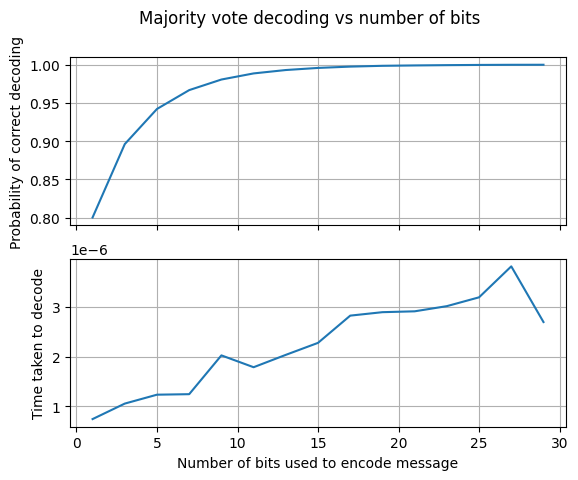

In [7]:
import matplotlib.pyplot as plt
import time

error_prob = 0.2 
num_trials = 500000
num_bits = range(1, 31, 2)
success_probs = []
decode_times = []

for n in num_bits:
    successes = 0
    total_time = 0

    for trial in range(num_trials):
        start_time = time.time()
        alice_intention = random.choice([0,1])
        alice_message = [alice_intention]*n
        bob_message = [send_bit(i, error_prob) for i in alice_message]
        bob_interpretation = decode_message(bob_message)
        trial_time = time.time() - start_time
        total_time += trial_time
        if bob_interpretation == alice_intention:
            successes += 1

    success_prob = float(successes/num_trials)
    success_probs.append(success_prob)

    decode_time = float(total_time/num_trials)
    decode_times.append(decode_time)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle("Majority vote decoding vs number of bits", fontsize=12)

ax1.plot(num_bits, success_probs)
ax1.set(
    ylabel="Probability of correct decoding",
    #title=f"Probability correct message is decoded using majority vote vs number of encoding bits. \n Error prob = {error_prob}."
    )
ax1.grid(visible=True)

ax2.plot(num_bits, decode_times)
ax2.set(
    xlabel="Number of bits used to encode message",
    ylabel="Time taken to decode",
    #title=f"Time taken to decode message using majority vote vs number of encoding bits. \n Error prob = {error_prob}."
    )
ax2.grid(visible=True)

plt.show

Ideally we want Bob to receive the message Alice intended with high probability as efficiently as possible.

### Encoding messages

Sometimes we want to communicate multiple pieces of information at once. Suppose Bob needs to know whether Alice is working from home today and tomorrow. Alice could use two switches, one for each day, sending the binary string $10$ if she is working today but not tomorrow.

Again to reduce the risk of errors, Alice can add redundancy. For example, she could send six bits instead of two, encoding $10$ as $111000$. Now Alice can send one of four possible binary strings: $$ 000000, 000111, 111000, 111111.$$ We can generalise this idea. Let $\mathcal{M}$ be the set of messages Alice wants to send. Choose an integer $n \in \{0,1\}^n$ and define an injective function $$ E \colon \mathcal{M} \to \{0,1\}^n. $$ Note you must choose $n$ so that $2^n$ is larger than the number of messages in $\mathcal{M}$ for such an injective function to exist. This function is shared with Bob to allow him to infer the intended message from the received string.

Of course, we still have the same issue: Bob may not receive one of the four binary strings sent by Alice. In fact, Bob could receive any $n$-bit string. Suppose Alice sends one of the four 6-bit codewords above and Bob receives $010111$. Previously we counted the most frequent value in the binary string to obtain the most likely codewood. However, now if we compare $010111$ to the possible messages sent by Alice:
| Sent binary string | Number of bit flips to get to $010111$ |
| ---                | ---                                    |
| $000000$ | 4 |
| $000111$ | 1 |
| $111000$ | 5 |
| $111111$ | 2 |

Therefore, we assume the most likely binary string that Alice sent is $000111$ and Bob takes this to be the intended message. 

This example can be generalised to obtain _error correcting codes_ by interpreting $\{0,1\}^n$ as a vector space and using linear algebra.

## Error correction codes

Fix an integer $n \in \mathbb{Z}_{>0}$. The binary strings of length $n$ are precisely the vectors in the vector space $(\mathbb{Z}/2\mathbb{Z})^n$. A _(binary) linear code_ of _length_ $n$ is a vector subspace $$\mathcal{C} \subseteq (\mathbb{Z}/2\mathbb{Z})^n.$$  An element of the code $\mathcal{C}$ is called a _codeword_. The _rank_ of a code is its dimension as a vector space over $\mathbb{Z}/2\mathbb{Z}$.

**Examples**

1. The set $\mathcal{C}_1 = \{(0,0,0), (1,1,1)\}$ is a vector subspace of $(\mathbb{Z}/2\mathbb{Z})^3$, and hence a code. The basis of the code is $\{(1,1,1)\}$. Thus, $\mathcal{C}_1$ is a code of length $3$ and rank $1$ that contains $2$ codewords.

2. The set $$\mathcal{C}_2 = \{(0,0,0),(1,1,0),(1,0,1),(0,1,1)\}$$ also forms a subspace of $(\mathbb{Z}/2\mathbb{Z})^3$, and so is a code. One basis of $\mathcal{C}_2$ is $\{(1,1,0),(1,0,1)\}$. Thus, $\mathcal{C}_2$ is a code of length $3$ and rank $2$ that contains $4$ codewords.

3. For any subset $S$ of $(\mathbb{Z}/2\mathbb{Z})^n$ the span $$\mathcal{C}(S) = \mathrm{Span}_{\mathbb{Z}/2\mathbb{Z}}(S)$$ defines a binary code of length $n$. The rank and number of codewords of $\mathcal{C}(S)$ depends on the linear relations between the elements of $S$.

Since a code is a vector subspace, a code is uniquely determined by a basis. A _generator matrix_ of a code is a matrix whose rows form a basis of the code. Note that a basis of a vector space is not unique and hence the generator matrix of a code is not unique either.

**Examples.**

1. One generator matrix for $\mathcal{C}_1$ is
$$ \begin{pmatrix} 1 & 1 & 1 \end{pmatrix}. $$

2. One generator matrix for $\mathcal{C}_2$ is
$$ \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}. $$

In [ ]:
import random

from linearcodes import LinearCode

# C1 = {000,111}

M1 = LinearCode([[0,0,0],[1,1,1]])
print(f"\nC1 has codewords: {M1.elements};")
print(f"  Length: {M1.length};")
print(f"  Rank: {M1.rank};")
G1 = M1.generator_matrix
print(f"  Generator matrix: \n{G1.array}.")

# C2 = {000,110,101,011}

M2 = LinearCode([[0,0,0],[1,1,0],[1,0,1],[0,1,1]])
print(f"\nC2 has codewords: {M2.elements};")
print(f"  Length: {M2.length};")
print(f"  Rank: {M2.rank};")
G2 = M2.generator_matrix
print(f"  Generator matrix: \n{G2.array}.")

# A random code C3

num_gen_elts = 3
binary_dimension = 5
elts = []
for elt in range(num_gen_elts):
    elt = []
    for bit in range(binary_dimension):
        elt.append(random.choice([0,1]))
    elts.append(elt)

M3 = LinearCode(elts)
codewords = M3.elements
print(f"\nC3 has {len(codewords)} codewords:")
print(f"  {codewords};")
print(f"  Length: {M3.length};")
print(f"  Rank: {M3.rank};")
G3 = M3.generator_matrix
print(f"  Generator matrix: \n{G3.array}.")


The generator matrix of a code $\mathcal{C}$ of length $n \in \mathbb{Z}_{>0}$ defines a linear map
$$G \colon (\mathbb{Z}/2\mathbb{Z})^n \to \mathcal{C}.$$
The kernel of this map is a vector subspace of $(\mathbb{Z}/2\mathbb{Z})^n$ and therefore forms another code. We call $\ker(G)$ the dual code of $\mathcal{C}$ and denote it by $\mathcal{C}^{\perp}$.

There is an equivalent characterisation of the dual code:
$$\mathcal{C}^{\perp} = \{ v \in (\mathbb{Z}/2\mathbb{Z})^n \mid c \cdot v = 0 \text{ for all } c \in \mathcal{C} \}.$$
These definitions agree because a vector $v$ satisfies $Gv = 0$ exactly when it is orthogonal to every row of the generator matrix, and these rows form a basis for $\mathcal{C}$. By the Rank Nullity Theorem, if $\mathcal{C}$ has length $n$ and rank $k$, then $\mathcal{C}^{\perp}$ has rank $n-k$. A generator matrix for $\ker(G)$ is called a parity check matrix of $\mathcal{C}$, denoted by $H$.

In summary we have:
| Code $\mathcal{C}$ | Dual code $\mathcal{C}^\perp$ |
| ---               | ---                           |
| Generator matrix $G$ | Generator matrix $H$ |
| Parity check matrix $H$ | Parity check matrix $G$ |

#### Examples.

1. The code $\mathcal{C}_1$ with generator matrix $$ G_1 = \begin{pmatrix} 1 & 1 & 1 \end{pmatrix}$$ has a parity check matrix $$ H_1 = \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}. $$

2. The code $\mathcal{C}_2$ with generator matrix $$ G_2 = \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}$$ has a parity check matrix  $$ H_2 = \begin{pmatrix} 1 & 1 & 1 \end{pmatrix}$$

In particular, the dual code of $\mathcal{C}_1$ is $\mathcal{C}_2$ and vice versa.






The parity check matrix detects whether a vector belongs to the code. A vector $v$ lies in $\mathcal{C}$ exactly when
$$Hv^{\mathrm{T}} = 0.$$
Each row of $H$ imposes a parity condition on a subset of the coordinates of $v$. The sum of the selected coordinates must be even, which corresponds to the parity check returning $0$.

The parity check matrix also allows us to detect errors in transmission. Errors are bit flips: a $0$ becomes a $1$ or a $1$ becomes a $0$. In $(\mathbb{Z}/2\mathbb{Z})^n$ this is the same as adding an error vector $e$ with a $1$ in each position where a bit has flipped. If Alice intends to send a codeword $c$ but Bob receives
$$m = c + e,$$
then applying the parity check matrix gives
$Hm^{\mathrm{T}} = Hc^{\mathrm{T}} + He^{\mathrm{T}} = He^{\mathrm{T}}.$
Since $Hc^{\mathrm{T}} = 0$, the vector $Hm^{\mathrm{T}}$ depends only on the error pattern. This vector is called the syndrome and it forms the basis of syndrome decoding.


##### Tanner Graph

The _Tanner graph_ of the code is a bipartite graph whose vertex sets are:
1. The set of bits in a codeword.
2. The parity check equations for the code.
Two vertices are connected if that bit is included in the parity check equation.

The generator matrix of a code $\mathcal{C}$ of length $n \in \mathbb{Z}_{>0}$ defines a linear map
$$G \colon (\mathbb{Z}/2\mathbb{Z})^n \to \mathcal{C}.$$
The kernel of this map is a vector subspace of $(\mathbb{Z}/2\mathbb{Z})^n$ and therefore forms another code. We call $\ker(G)$ the dual code of $\mathcal{C}$ and denote it by $\mathcal{C}^{\perp}$.

There is an equivalent characterisation of the dual code:
$$\mathcal{C}^{\perp} = \{ v \in (\mathbb{Z}/2\mathbb{Z})^n \mid c \cdot v = 0 \text{ for all } c \in \mathcal{C} \}.$$
These definitions agree because a vector $v$ satisfies $Gv = 0$ exactly when it is orthogonal to every row of the generator matrix, and these rows form a basis for $\mathcal{C}$. By the Rank Nullity Theorem, if $\mathcal{C}$ has length $n$ and rank $k$, then $\mathcal{C}^{\perp}$ has rank $n-k$. A generator matrix for $\ker(G)$ is called a parity check matrix of $\mathcal{C}$, denoted by $H$.

In summary we have:
| Code $\mathcal{C}$ | Dual code $\mathcal{C}^\perp$ |
| ---               | ---                           |
| Generator matrix $G$ | Generator matrix $H$ |
| Parity check matrix $H$ | Parity check matrix $G$ |

**Examples.**

1. The repetition code of length $3$ (the code $\mathcal{C}_1$) has generator matrix $$ G_1 = \begin{pmatrix} 1 & 1 & 1 \end{pmatrix}$$ has a parity check matrix $$ H_1 = \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}. $$

2. The code $\mathcal{C}_2$ with generator matrix $$ G_2 = \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}$$ has a parity check matrix  $$ H_2 = \begin{pmatrix} 1 & 1 & 1 \end{pmatrix}$$

In particular, the dual code of $\mathcal{C}_1$ is $\mathcal{C}_2$ and vice versa.



In [35]:
import random

from linearcodes import LinearCode

# C1 = {000,111}

M1 = LinearCode([[0,0,0],[1,1,1]])
print(f"\nC1 has codewords: {M1.elements};")
print(f"  Length: {M1.length};")
print(f"  Rank: {M1.rank};")
G1 = M1.generator_matrix
print(f"  Generator matrix: \n{G1.array}.")
H1 = M1.parity_check_matrix
print(f"  Parity check matrix: \n{H1.array}")

# C2 = {000,110,101,011}

M2 = LinearCode([[0,0,0],[1,1,0],[1,0,1],[0,1,1]])
print(f"\nC2 has codewords: {M2.elements};")
print(f"  Length: {M2.length};")
print(f"  Rank: {M2.rank};")
G2 = M2.generator_matrix
print(f"  Generator matrix: \n{G2.array}.")
H2 = M2.parity_check_matrix
print(f"  Parity check matrix: \n{H2.array}")

# A random code C3

num_gen_elts = 3
binary_dimension = 5
elts = []
for elt in range(num_gen_elts):
    elt = []
    for bit in range(binary_dimension):
        elt.append(random.choice([0,1]))
    elts.append(elt)

M3 = LinearCode(elts)
codewords = M3.elements
print(f"\nC3 has {len(codewords)} codewords:")
print(f"  {codewords};")
print(f"  Length: {M3.length};")
print(f"  Rank: {M3.rank};")
G3 = M3.generator_matrix
print(f"  Generator matrix: \n{G3.array}.")
H3 = M3.parity_check_matrix
print(f"  Parity check matrix: \n{H3.array}")



#### Hamming distance

We can simplify the Maximum Likelihood Decoder by using the Hamming distance. Recall maximising $\mathbb{P}(c \mid m)$ is equivalent to maximising $\mathbb{P}(m \mid c) = \prod_{i=1}^n \mathbb{P}(m_i \mid c_i)$. Let us assume we have a binary symmetric channel such that the probability the probability a bit flips is $p$. Therefore, we have that
$$
\mathbb{P}(m_i \mid c_i) =
\begin{cases}
p & \text{if } m_i \neq c_i, \\
1-p & \text{if } m_i = c_i.
\end{cases}
$$
Notice that the probabilities depend only whether the bits are the same or different. In particular, the power of $p$ in the product $\prod_{i=1}^n \mathbb{P}(m_i \mid c_i)$ is precisely the number of bits in $m$ that differ from the bits in $c$, that is the Hamming distance $d(m,c)$. Therefore, we have that 
$$\mathbb{P}(m \mid c) = \prod_{i=1}^n \mathbb{P}(m_i \mid c_i) = p^{d(m,c)}(1-p)^{n-d(m,c)}.$$
Rearranging this expression we obtain
$$\mathbb{P}(m \mid c) = \left( \frac{p}{1-p}\right)^{d(m,c)}  \cdot (1-p)^{n}.$$
Note that $(1-p)^{n}$ depends neither on the codeword $c$ nor the message $m$. Thus, maximising $\mathbb{P}(m \mid c)$ over $\mathcal{C}$ is equivalent to maximising
$$\left( \frac{p}{1-p}\right)^{d(m,c)}$$
over $\mathcal{C}$.

By convention we assume that $p < \frac{1}{2}$. If it is not, then we can assume the received message is more likely to be wrong and flip all the bits before working with them .... (Fix this phrasing!). Consequently, the value $\frac{p}{1-p}$ is less than $1$ and so to maximise $$\left( \frac{p}{1-p}\right)^{d(m,c)}$$ we must minimise $d(m,c)$. In particular, we have that the codeword $\hat{c}$ that maximises $\mathbb{P}(c \mid m)$ is precisely the codeword that minimises $d(m,c)$.

---
#### Example.

Let us consider the example $\mathcal{C} = \{000,111\}$ again. Suppose we receive the message $m=100$. We know from previous computations that the most likely codeword that was sent is $c=000$. We can recompute this using the Hamming distance. In particular, we have that
$$ d(m=100,c=000) = 1 \; \text{ and } \; d(m=100,c=111) = 2 $$
and so $c=000$ minimises the Hamming distance.

As before we can compute the Hamming distance and most likely codeword for all possible messages $m \in \{0,1\}^3$.
| Message $m$   | $d(m, c=000)$ | $d(m, c=111)$ | Most likely codeword $c$ |
| ---                    | ---                    | ---                    | ---             |
| 000                    | 0        | 3         | 000  |
| 100, 010, 001          | 1         | 2         | 000  |
| 110, 101, 011          | 2         | 1         | 111  |
| 111                    | 3         | 0        | 111  |
---

<!-- 

Moreover, since the log function is monotonically increasing maximising $\mathbb{P}(m \mid c)$ is equivalent to maximising $\mathrm{log}(\mathbb{P}(m \mid c)) $. (TODO: make this a more natural jump.) By applying the log function we obtain
$$ \mathrm{log}(\mathbb{P}(m \mid c)) = \mathrm{log}(\prod_i \mathbb{P}(m_i \mid c_i)) = \sum_i \mathrm{log}(\mathbb{P}(m_i \mid c_i)). $$
Now recall that for a binary symmetric channel we assume that 
In particular, it depends only on when bits are the same and when they are not, similar to the Hamming distance. Thereofore, by using the Hamming distance between two codewords we obtain
$$ \sum_i \mathrm{log}(\mathbb{P}(m_i \mid c_i)) = d(c,m)\mathrm{log}(p) + (1-d(c,m))\mathrm{log}(1-p). $$
Simplifying this we obtain
$$ \sum_i \mathrm{log}(\mathbb{P}(m_i \mid c_i)) =  d(c,m)\mathrm{log}(\frac{p}{1-p}) + \mathrm{log}(1-p). $$
Notice that $\mathrm{log}(1-p)$ does not depend on $c$, so maximising $\mathbb{P}(c \mid m)$ is equivalent to maximising $$d(c,m)\mathrm{log}(\frac{p}{1-p})$$. Since we assume that $p < 0.5$, we have that $\mathrm{log}(\frac{p}{1-p})$ is negative. Thus, maximising over $d(c,m)\mathrm{log}(\frac{p}{1-p})$ is equivalent to minimsiing over $d(c,m)$. Therefore, we have that
$$ \mathrm{max}_{c \in \mathcal{C}} (\mathbb{P}(c \mid m)) = \mathrm{min}_{c \in \mathcal{C}} (d(c,m)).$$

#### Example

Take the previous example with the code $\mathcal{C} = \{000,111\}$. We can easily compute the Hamming distances between any message $m$ and codeword $c$ to obtain the following table:

| Message $m$   | $d(m, c=000)$ | $d(m, c=111)$ | Closest = most likely codeword |
| ---                    | ---                    | ---                    | ---             |
| 000                    | 0        | 3         | 000  |
| 100, 010, 001          | 1         | 2         | 000  |
| 110, 101, 011          | 2         | 1         | 111  |
| 111                    | 3         | 0        | 111  | 

---
-->
Using the Hamming distance makes it faster to apply the maximum likelihood decoder. However, for a code $\mathcal{C}$ with rank $k$, it still requires computing and comparing $2^k$ different numbers. Therefore, as the code gets bigger the Maximum Likelihood Decoder becomes computationally impractical. We need more efficient algorithms that estimate the most likely codeword without having to compute the Hamming distances explicitly.

In [42]:
from linearcodes import Codeword, LinearCode, HammingCode
import random
import numpy as np
import time

def send_codeword(
        code_length: int,
        channel_probabilities: list[float],
        codeword: Codeword):
    if len(channel_probabilities) != code_length:
        raise ValueError(f"List of probabilities must be of length code_length={code_length}. Got {len(channel_probabilities)}.")
    if len(codeword) != code_length:
        raise ValueError(f"Codeword must of length code_length={code_length}. Got {len(codeword)}.")
    message = []
    for bit_idx in range(code_length):
        p = channel_probabilities[bit_idx]
        c = codeword.vector[bit_idx]
        r = np.random.uniform(0,1)
        if r < p:
            flip_bit = (c+1)%2
            message.append(flip_bit)
        else:
            message.append(c)
    return message

def hamming_distance(x: list[int], y: list[int]) -> int:
    if len(x) != len(y):
        raise ValueError("Both x and y must be the same length.")
    return sum([1 for bit_idx in range(len(x)) if x[bit_idx] != y[bit_idx]])


def minimise_hamming_distance(code_length: int,
                              codewords: list[Codeword],
                              message: list[int]) -> Codeword:
    """
    Returns the codeword that was most likely to be sent given message is received using Hamming distance.
    Args:
        - channel_probabilities (list[float]):
            entry with index i is the probability bit i will flip.
        - code (lc.LinearCode):
            code used for encoding.
        - message (list[int]):
            received message.
    """
    if len(message) != code_length:
        raise ValueError(f"Message must be of length {code_length}. Got {len(message)}.")
    most_likely_codeword = Codeword([0]*code_length)
    min_hamming_dist = code_length
    for c in codewords:       
        hamming_dist = hamming_distance(c.vector, message)
        if hamming_dist < min_hamming_dist:
            most_likely_codeword = c
            min_hamming_dist = hamming_dist
    return most_likely_codeword

code = HammingCode(3)
code_length = code.length
codewords = code.codewords
channel_probabilities = [float(0.1)]*code_length
results: dict[int, tuple[bool, float]] = {}

num_trials = 10
for trial in range(num_trials):
    print(f"\n=== Minimise Hamming distance decoder {trial+1} ===")
    codeword = random.choice(codewords)

    message = send_codeword(code_length, channel_probabilities, codeword)
    start_time = time.time()
    most_likely_codeword = minimise_hamming_distance(code_length, codewords, message)
    decode_time = time.time() - start_time

    print(f"\nRows are: sent codeword c, received message m, most likely sent codeword c'.")
    data = np.array([codeword.vector, message, most_likely_codeword.vector])
    print(data)

    decode_correct = codeword == most_likely_codeword
    print(f"\nDecoding correct? {decode_correct}")
    print(f"Actual number of errors: {sum(1 for bit_idx in range(code_length) if codeword.vector[bit_idx] != message[bit_idx])}")
    print(f"Guessed number of errors: {sum(1 for bit_idx in range(code_length) if most_likely_codeword.vector[bit_idx] != message[bit_idx])}")

    results[trial] = (decode_correct, decode_time)
    print(f"\nDecode correct? {decode_correct}")
    print(f"Time to decode = {decode_time*(10**5):.3f}x10^5")


=== Minimise Hamming distance decoder 1 ===

Rows are: sent codeword c, received message m, most likely sent codeword c'.
[[1 0 1 0 0 1 0]
 [1 1 1 0 0 1 0]
 [1 0 1 0 0 1 0]]

Decoding correct? True
Actual number of errors: 1
Guessed number of errors: 1

Decode correct? True
Time to decode = 12.827x10^5

=== Minimise Hamming distance decoder 2 ===

Rows are: sent codeword c, received message m, most likely sent codeword c'.
[[0 0 0 0 1 1 1]
 [0 0 0 0 1 1 1]
 [0 0 0 0 1 1 1]]

Decoding correct? True
Actual number of errors: 0
Guessed number of errors: 0

Decode correct? True
Time to decode = 2.313x10^5

=== Minimise Hamming distance decoder 3 ===

Rows are: sent codeword c, received message m, most likely sent codeword c'.
[[1 0 1 0 1 0 1]
 [1 0 1 0 1 1 1]
 [1 0 1 0 1 0 1]]

Decoding correct? True
Actual number of errors: 1
Guessed number of errors: 1

Decode correct? True
Time to decode = 2.170x10^5

=== Minimise Hamming distance decoder 4 ===

Rows are: sent codeword c, received messa

The generator matrix of the dual code $\mathcal C^{\perp}$ of a code $\mathcal{C}$ is called the parity check matrix of $\mathcal{C}$ and is denoted by $H$. The parity check matrix is useful to determine vectors that are codewords of $\mathcal{C}$. Each of the rows of $H$ is a codeword in the dual code $\mathcal{C}^\perp$. Therefore, its dot product with a codeword of $\mathcal{C}$ is 0 and we have a vector $v \in (\mathbb Z/2\mathbb Z)^n$ lies in the code $\mathcal C$ if and only if $$H v^{\mathrm T} = 0.$$
Each row of $H$ is a vector of $0$'s and $1$'s. Therefore, each row defines an equation that adds up a subset of the coordinates of $v$ which we call _parity check equations_. For a vector to lie in the codespace each of these equations must given even parity.

---
**Example.** Consider the repetition code of length three with generator matrix
$G_1 = \begin{pmatrix} 1 & 1 & 1 \end{pmatrix}.$
A parity check matrix for this code is
$H_1 = \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}.$
Since the parity check matrix has two rows, there are two parity check equations. In particular, for $v = (v_1, v_2, v_3)$ we have
$$P_1(v) = v_1 + v_2 \; \text{ and } \; P_2(v) = v_2 + v_3.$$
The vector $v$ is a codeword exactly when both sums have even parity.

---

#### Tanner graphs

A Tanner graph is a bipartite graph associated with a parity check matrix. It has two types of vertices:
1. "Bit vertices"
2. "Check vertices"

The bit vertices correspond to bit indices in a codeword, so for a code of length $n$ there are $n$ bit vectices. The check vertices correspond to parity check equations, so for a code of length $n$ and rank $k$, there are $n-k$ check vertices. A bit vertex is connected to a check vertex when that bit appears in that parity check equation. Tanner graphs visualise the structure of a code and are used in iterative decoding algorithms.

#### Syndromes.

The parity check equations can be used to detect errors. Recall that an error is a bit-flip: either $0$ becomes $1$ or $1$ becomes $0$. In $(\mathbb{Z}/2\mathbb{Z})$, this is equivalent to adding $1$. Therefore, an error can be represented by an error vector $e$, with a $1$ in each position where a bit flip occurred.

If we send a codeword $c$ and receive a message $m$, there exists an error vector $e$ such that $$m=c+e.$$ Applying the parity check matrix gives $$H m^{\mathrm T} = H c^{\mathrm T} + H e^{\mathrm T} = H e^{\mathrm T}.$$ The vector $H e^{\mathrm{T}}$ depends only on the error pattern and is called the _syndrome_. Distinct error patterns can produce distinct syndromes, which allows us to detect and correct errors.


---
**Example.** The repetition code of length $3$ has a parity check matrix $H = \begin{pmatrix} 1 & 1 & 0 \\ 1 & 0 & 1 \end{pmatrix}.$ There are three possible single-bit flip errors, one for each bit. The syndromes of these error are as follows:
| Error | Error vector $e$ | Syndrome $He^\mathrm{T}$ |
| ---   | ---              | ---                      |
| First bit flips | 100 | 11 |
| Second bit flips | 010 | 10 |
| Third bit flips | 001 | 01 |

Each single-bit flip has a unique syndrome, so assuming only one error occurs, we can uniquely determine which bit was flipped.

However, if more than one error occurs, the syndrome may no longer be unique. For example, if the second and third bits flip we have that $e = 011$ and so $$ He^\mathrm{T} = 11$$ which is the same as the syndrome for a single flip of the first bit.

---

We have seen that syndromes do not always uniquely determine the errors that occur. However, there is a class of codes where like in the repetition code of length $3$ each _single_ bit error can be uniquely identified by its syndrome. That is, Hamming codes.

### Hamming codes

Hamming codes are designed to make the syndromes for single bit errors distinct. They are defined via the parity check matrix.

**Definition.** Fix an integer $r>0$. A Hamming code $\mathcal{C}$ of length $2^r-1$ has parity check matrix $H$ whose columns are all the non-zero vectors in $\{0,1\}^r$.

---
**Example.** Fix $r=3$. The Hamming code with dual code of length $2^3-1 = 7$ has parity check matrix
$$ H = 
\begin{pmatrix}
1 & 0 & 0 & 1 & 1 & 0 & 1 \\
0 & 1 & 0 & 1 & 0 & 1 & 1 \\
0 & 0 & 1 & 0 & 1 & 1 & 1
\end{pmatrix}. $$

---